In [5]:
import os

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [38]:
plt.style.use('ggplot')

### Number of files

In [4]:
data_folder = "../data"

In [3]:
ls ../data

item_categories.csv  sales_train.csv        shops.csv
items.csv            sample_submission.csv  test.csv


In [6]:
df_item_categories = pd.read_csv(os.path.join(data_folder, "item_categories.csv"))

In [8]:
df_item_categories.head(4)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3


`item_categories.csv` contains a mapping from category_name to category_id. There are total $83$ unique categories of items. 

In [9]:
df_items = pd.read_csv(os.path.join(data_folder, "items.csv"))

In [10]:
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


`items.csv` provide information for each items in the shops. This file contains the name of the item, its unique id, and the category that this item belongs to. There are total $22170$ unique items present in the shops. 

In [13]:
df_shops = pd.read_csv(os.path.join(data_folder, "shops.csv"))

In [17]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


`shops.csv` contains the information about shops. It contains the name of each shop and the unique id associated with it. There are total $60$ shops.

In [18]:
df_sales_train = pd.read_csv(os.path.join(data_folder, "sales_train.csv")) 

In [19]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


`sales_train.csv` is the main file. It contains the information about sales of each item per day. The fileds in the data are as following:
1. *date_block_num* is a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33.
2. *date* is just the date
3. *shop_id* is the shop from which the item is purchased
4. *item_id* is the unique identifier of the item that is purchased
5. *item_price* contains the current price of the item.
6. *item_cnt_day* is the amount of item that is purchased on that particular day.

### Q. What are the interesting information that can be gather from this data?
1. Life cycle of an item. 
2. Periodic property in the sales of an item.
3. Coorelation between price and sales for a given category

#### Popularity of items

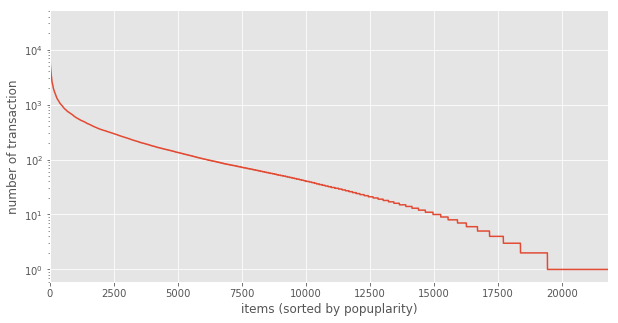

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(df_sales_train
 .item_id
 .value_counts()
 .reset_index(drop=True)
 .plot(logy=True, ax=ax))
ax.set_xlabel("items (sorted by popuplarity)")
ax.set_ylabel("number of transaction")

As is true in most of the cases in nature, the popularity of an item is highly skewed. Some items have transactions $5000$ times and $33\%$ of the items have total sales less than 10 items in the duration of one and half year. 

#### Popularity of item categories

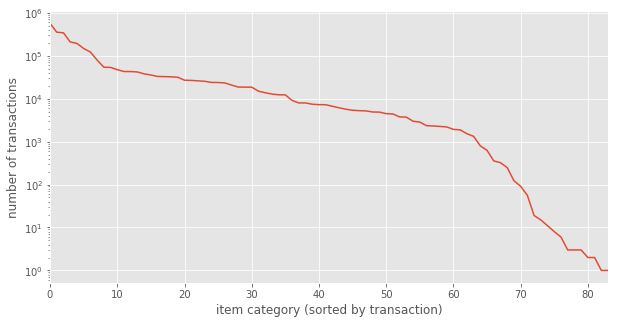

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(df_sales_train[["item_id"]]
 .merge(df_items, on="item_id", how="left")
 .item_category_id
 .value_counts()
 .reset_index(drop=True)
 .plot(logy=True, ax=ax))
ax.set_xlabel("item category (sorted by transaction)")
ax.set_ylabel("number of transactions")

This curve looks interesting. It seems like it is form from two linear curves. We can add this feature that describes the popularity of a category.

#### Popularity of shops

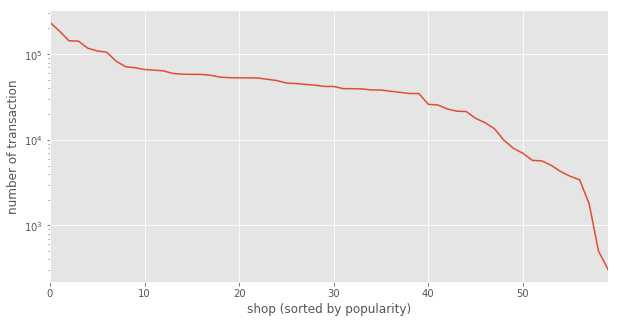

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(df_sales_train
 .shop_id
 .value_counts()
 .reset_index(drop=True)
 .plot(logy=True))
ax.set_xlabel("shop (sorted by popularity)")
ax.set_ylabel("number of transaction")

Again very similar curve for the popularity of shops. 

#### Periodicity in the sales of an items

In [62]:
pd.to_datetime?

In [63]:
df_sales_train["date"] = pd.to_datetime(df_sales_train.date, format="%d.%m.%Y")

In [57]:
df_item_value_counts = df_sales_train.item_id.value_counts()
def get_ith_popular_item(i):
    return df_item_value_counts.index[i]

In [90]:
def plot_sales_of_ith_popular_item(i):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    (df_sales_train
     [df_sales_train.item_id == get_ith_popular_item(i)]
     [["date_block_num", "item_cnt_day"]]
     .groupby("date_block_num")
     .aggregate("mean")
     .plot(ax=ax))
    ax.set_xlabel("month")
    ax.set_ylabel("average sale per day in that month")
    ax.legend("")
    ax.set_title("sales of {}-th popular item as month varies".format(i + 1))

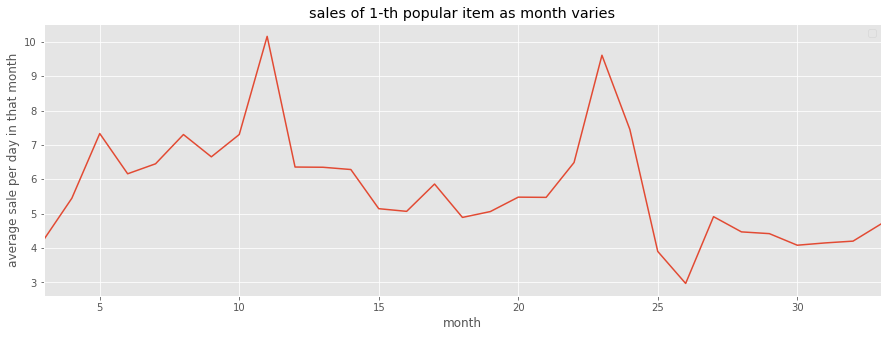

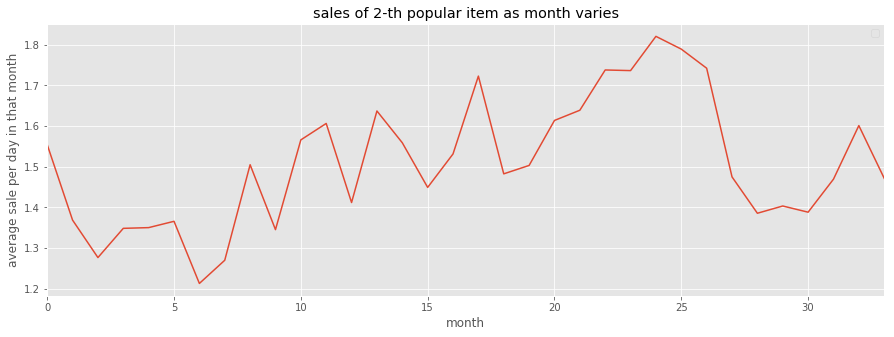

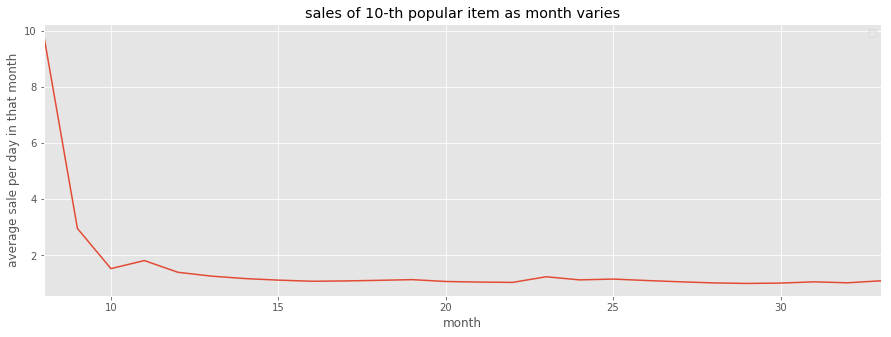

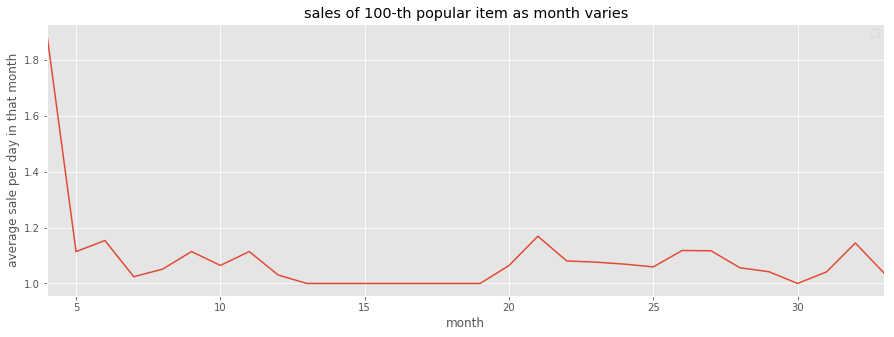

In [91]:
plot_sales_of_ith_popular_item(0)
plot_sales_of_ith_popular_item(1)
plot_sales_of_ith_popular_item(9)
plot_sales_of_ith_popular_item(99)

Except for the most popular item, at the first glance the sales of each item doesn't seem to have much impacted by month.

#### For a given category, see how does the sales are related to price

In [99]:
df_item_category_sales = (df_sales_train
                          [["item_id", "item_cnt_day", "item_price"]]
                          .merge(df_items, on="item_id", how="left")
                          .groupby("item_category_id"))

In [118]:
popular_categories = (df_item_category_sales.agg({"item_id": len})
                      .sort_values("item_id", ascending=False)
                      .index)

In [123]:
def plot_sale_vs_price_for_category(i):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    (df_item_category_sales
     .get_group(i)
     .groupby("item_id")
     .aggregate({"item_price": "mean", "item_cnt_day": sum})
     .sort_values("item_price")
     .plot(x="item_price", y="item_cnt_day", ax=ax, legend=False))
    ax.set_xlabel("average item price")
    ax.set_ylabel("toal sales")
    ax.set_title("sales of items as a function of price in {}-th category".format(i))

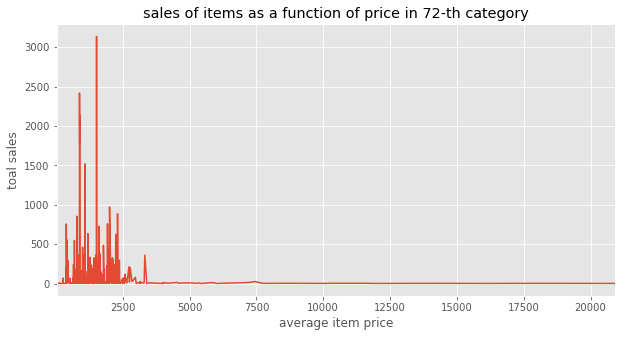

In [130]:
plot_sale_vs_price_for_category(popular_categories[10])